# Layout Study

Exploring the results of the project so far, experimenting creatively.

In [242]:
import json
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

## Taille des Pages

We first start by looking at the size of the pages, because we suspect that some documents have been digitalized one page by one page, and other two pages at the same time.

In [4]:
with open("./data/illu_pos.json") as f:
    data = json.load(f)

We compute the aspect ratio of each image.

In [10]:
aspect_ratios = dict()
for k, v in data.items():
    aspect_ratios[k] = v["im_w"]/v["im_h"]

And plot the distribution

<AxesSubplot:ylabel='Count'>

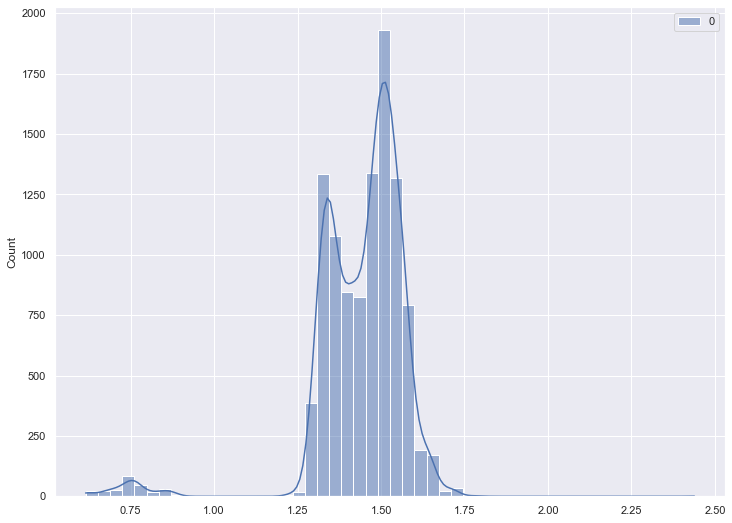

In [24]:
sns.set(rc={'figure.figsize':(12,9)})
sns.set_style('darkgrid')
sns.histplot(aspect_ratios.values(), bins=50, kde=True)

We indeed see two spikes in the distribution, corresponding to the two modes of digitization. For some later analysis we will need to separate these two categories. Let's look at the median values for the two classes. We assume that an aspect ration > 1 means that there is one page on the image, and < 1 means that there are two pages.

In [39]:
aspcrat = pd.DataFrame.from_dict(aspect_ratios, orient='index').rename(columns={0 : "aspect ratio"})

In [337]:
median = aspcrat[aspcrat["aspect ratio"] < 1].median(axis=0)
median_2p = median["aspect ratio"]
median_2p

0.7540993653789224

In [338]:
median_1p = aspcrat[aspcrat["aspect ratio"] > 1].median(axis=0)
median_1p = median_1p["aspect ratio"]
median_1p

1.4750390990891713

## Heatmap

Now, the idea is to get a grasp of the position of the illustrations in the journals. We will use heatmaps to illustrate that the distribution of the positions of illustrations in the journals.

### On two pages layouts

We start with the journals that have been digitized two pages by two pages.

In [57]:
two_p = list(aspcrat[aspcrat["aspect ratio"] < 1].index)
two_p = { k: data[k] for k in two_p }

On the heatmap, the whiter a pixel is, the more illustrations are at this place. We build it by looping over all the illustrations positions and incrementing the values when it corresponds to the illustration's place. We also resize all the images to the median aspect ratio. 

In [368]:
def heatmap_data(dict_data, height, width):
    d = np.zeros((width, height))
    for page in dict_data.values():
        for x in range(int(page["x_1"] * width), int(page["x_2"] * width)):
            for y in range(int(page["y_2"] * height), int(page["y_1"] * height)):
                d[x][y] += 1
    return d

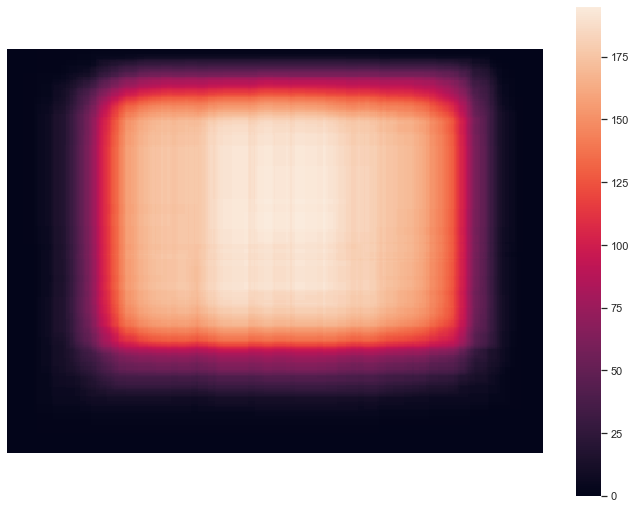

In [369]:
ax = sns.heatmap(heatmap_data(two_p, 500, int(median_2p*500)), xticklabels=False, yticklabels=False, square=True)

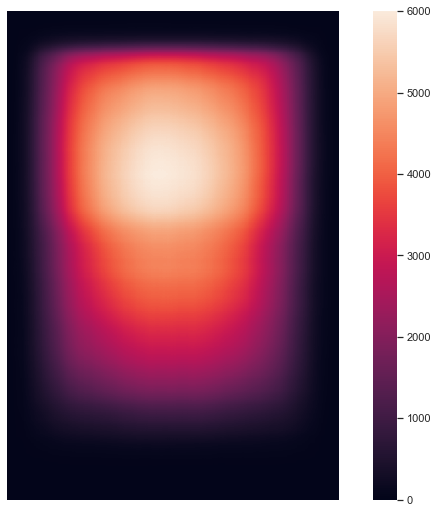

In [370]:
one_p = list(aspcrat[aspcrat["aspect ratio"] > 1].index)
one_p = { k: data[k] for k in one_p }
ax = sns.heatmap(heatmap_data(one_p, 500, int(median_1p*500)), xticklabels=False, yticklabels=False, square=True)

### Per journal

Now we have a very global idea of how the illustrations are distributed within the pages. We can reproduce this process but using more precise subset of journals. We will try to plot one heatmap per journal name.

In [372]:
# Dataframe that links the an illustration and its journal, name and id
df = pd.read_csv("./data/data.csv")

In [377]:
# Get the ids of the journals that have at least 1 illustration in them
j_ids = list(df.groupby("_journal-id").count()["id"].sort_values(ascending=False).index)
j_ids = [int(j) for j in j_ids]
j_illu_ids = []
for j in j_ids:
    one_j_ids = list(df[df["_journal-id"] == j]["id"])
    one_j = {k: data[k] for k in data.keys() if int(k.split("_")[1]) in one_j_ids}
    if len(aspcrat.loc[one_j.keys()]) > 0 :
        j_illu_ids.append(j)

In [378]:
# Create mapping between journal id and journal name
journals_map_ids = dict()
j_illu_n_ids = []
for j in j_illu_ids:
    try:
        journals_map_ids[j] = df[df["_journal-id"]==j].iloc[0]["_journal-name"][:15]
        j_illu_n_ids.append(j)
    except:
        pass

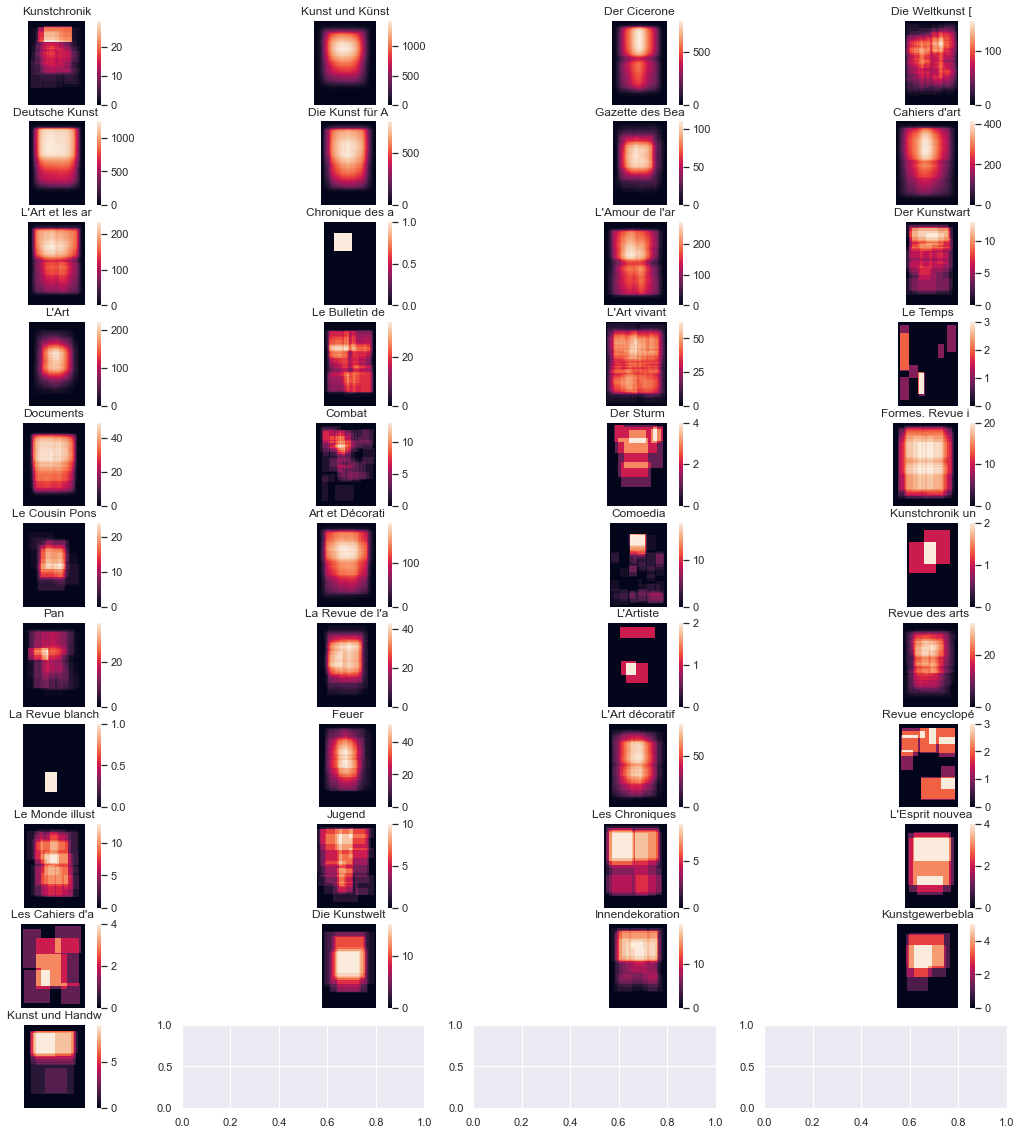

In [371]:
# Plot heatmaps for every journal
fig, axs = plt.subplots(int(len(j_illu_n_ids)/4) + 1, 4, sharex=False, sharey=False, figsize=(20,20))
for journal, ax in zip(j_illu_n_ids, axs.flatten()):
    one_j_ids = list(df[df["_journal-id"] == journal]["ID"])
    one_j = {k: data[k] for k in data.keys() if int(k.split("_")[1]) in one_j_ids}
    median = aspcrat.loc[one_j.keys()].median(axis=0)["aspect ratio"]
    sns.heatmap(heatmap_data(one_j, 100, int(median*100)), xticklabels=False, yticklabels=False, square=True, ax=ax)
    ax.set_title(journals_map_ids[journal])

In [ ]:
# TODO : heatmap per illustration type